Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 596s 12s/step - accuracy: 0.8868 - dice_coef: 0.2733 - iou_score: 0.2380 - loss: 0.3523 - val_accuracy: 0.9313 - val_dice_coef: 0.2871 - val_iou_score: 0.2454 - val_loss: 0.2611 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 526s 11s/step - accuracy: 0.9741 - dice_coef: 0.3780 - iou_score: 0.3192 - loss: 0.0824 - val_accuracy: 0.8469 - val_dice_coef: 0.2740 - val_iou_score: 0.2207 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 533s 11s/step - accuracy: 0.9649 - dice_coef: 0.3690 - iou_score: 0.3125 - loss: 0.1114 - val_accuracy: 0.8924 - val_dice_coef: 0.2988 - val_iou_score: 0.2499 - val_loss: 0.3000 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 576s 12s/step - accuracy: 0.9604 - dice_coef: 0.3732 - iou_score: 0.3136 - loss: 0.1214 - val_accuracy: 0.8795 - val_dice_coef: 0.3220 - val_iou_score: 0.2665 - val_loss: 0.2817 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 51

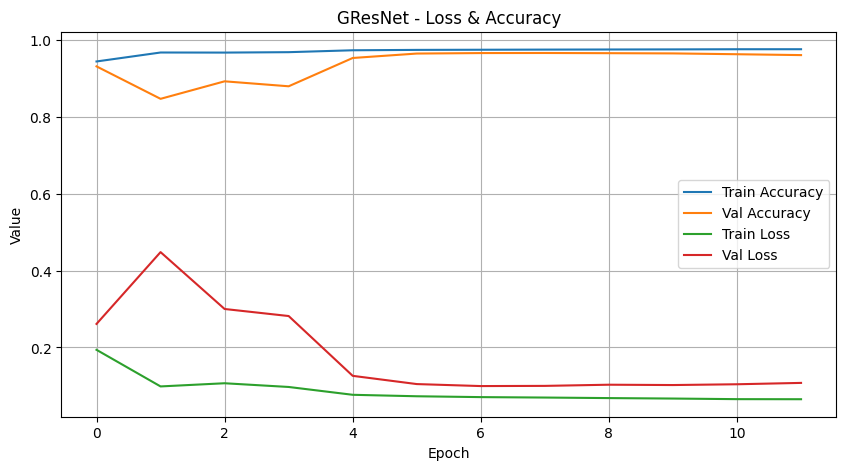

In [2]:
# Script: gresnet_training.py
# Purpose: Train a memory-efficient GResNet model using a data generator on sampled_128

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

# -------------------------------
# 1. MOUNT GOOGLE DRIVE
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/sampled_128"

# -------------------------------
# 2. DATA GENERATOR (DOWNSAMPLED)
# -------------------------------
class VolumeDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=1, shuffle=True):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.npy')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.npy')))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_img_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_img_paths]
        masks = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_mask_paths]

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(temp)
            self.image_paths, self.mask_paths = zip(*temp)

# -------------------------------
# 3. GResNet BLOCK
# -------------------------------
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv3D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Match shortcut channels if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, 1, padding='same')(shortcut)

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x


# -------------------------------
# 4. GResNet MODEL
# -------------------------------
def gresnet(input_shape=(64,64,64,3), n_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv3D(16, 3, padding='same', activation='relu')(inputs)
    c1 = residual_block(c1, 16)
    p1 = layers.MaxPooling3D((2,2,2))(c1)

    c2 = layers.Conv3D(32, 3, padding='same', activation='relu')(p1)
    c2 = residual_block(c2, 32)
    p2 = layers.MaxPooling3D((2,2,2))(c2)

    c3 = layers.Conv3D(64, 3, padding='same', activation='relu')(p2)
    c3 = residual_block(c3, 64)
    p3 = layers.MaxPooling3D((2,2,2))(c3)

    # Bridge
    b = layers.Conv3D(128, 3, padding='same', activation='relu')(p3)
    b = residual_block(b, 128)

    # Decoder with residuals
    u3 = layers.UpSampling3D((2,2,2))(b)
    u3 = layers.Conv3D(64, 1, padding='same')(u3)
    u3 = layers.Concatenate()([u3, c3])
    d3 = residual_block(u3, 64)

    u2 = layers.UpSampling3D((2,2,2))(d3)
    u2 = layers.Conv3D(32, 1, padding='same')(u2)
    u2 = layers.Concatenate()([u2, c2])
    d2 = residual_block(u2, 32)

    u1 = layers.UpSampling3D((2,2,2))(d2)
    u1 = layers.Conv3D(16, 1, padding='same')(u1)
    u1 = layers.Concatenate()([u1, c1])
    d1 = residual_block(u1, 16)

    outputs = layers.Conv3D(n_classes, 1, activation='softmax')(d1)

    model = models.Model(inputs, outputs)
    return model

# -------------------------------
# 5. METRICS
# -------------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth))

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    return tf.reduce_mean((intersection + smooth) / (union - intersection + smooth))

# -------------------------------
# 6. TRAINING
# -------------------------------
train_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'train/images'),
    mask_dir=os.path.join(data_path, 'train/masks'),
    batch_size=1
)

val_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'val/images'),
    mask_dir=os.path.join(data_path, 'val/masks'),
    batch_size=1
)

model = gresnet(input_shape=(64, 64, 64, 3), n_classes=4)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', dice_coef, iou_score])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    callbacks=callbacks)

# -------------------------------
# 7. EVALUATION + PLOT
# -------------------------------
final_metrics = model.evaluate(val_gen, verbose=0)
print(f"\nFinal Validation Metrics:")
print(f"Loss:         {final_metrics[0]:.4f}")
print(f"Accuracy:     {final_metrics[1]:.4f}")
print(f"Dice Coef:    {final_metrics[2]:.4f}")
print(f"IoU Score:    {final_metrics[3]:.4f}")

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('GResNet - Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
